## [PS S3E33] Binary Classification with a Software Defects Dataset


# Abstract


In this episode, my main goal was to understand the stacking ensemble. Since the training and test data had the same distribution, which was close to normal after a simple transformation, I did not spend much time on data cleaning and feature engineering. Thus, the most valuable part of this submission is the Stacking section.

# Import libraries


In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score


from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from rgf.sklearn import RGFClassifier
from sklearn.ensemble import HistGradientBoostingClassifier


from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

import optuna

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)

pd.set_option("display.max_columns", None)

# Mute warnings
import warnings

# Suppress warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

/tmp/ipykernel_20/3664761019.py:28: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [2]:
PATH = "/kaggle/input/playground-series-s3e23"

In [3]:
target = "defects"
rng = 2

## Usefull functions


In [4]:
def get_numerical(df: pd.DataFrame):
    return df.select_dtypes(include=["number"]).columns


def get_categorical(df: pd.DataFrame):
    return df.select_dtypes(include=["categorical"]).columns


def add_dataset(df: pd.DataFrame):
    return df.assign(
        dataset=df[target].isna().replace([True, False], ["train", "test"])
    )

# First look


In [5]:
data_dir = Path(PATH)

df_train = pd.read_csv(data_dir / "train.csv")
df_test = pd.read_csv(data_dir / "test.csv")

df_train[target] = df_train[target].astype("int")
df_train.drop(["id"], axis=1, inplace=True)
df_test.drop(["id"], axis=1, inplace=True)

df = pd.concat([df_train, df_test], ignore_index=True)
print(f"Train dataset shape: { df_train.shape }")
print(f"Test dataset shape: { df_test.shape }")
print(f"Concatinated dataset shape: { df.shape }")
print("Loaded successfully")

Train dataset shape: (101763, 22)
Test dataset shape: (67842, 21)
Concatinated dataset shape: (169605, 22)
Loaded successfully


## Missing values


In [6]:
missing_values = df.columns[df.isnull().any()].drop([target])
missing = df[missing_values].isnull().sum() / df.shape[0] * 100
if len(missing) > 0:
    missing.plot.barh(
        title="Percentage of missing values", xlabel="Percentage", ylabel="Features"
    )
else:
    print("No missing values!")

No missing values!


## Duplicated values


In [7]:
if df_train.duplicated().sum() == 0:
    print("No dulicated values")
else:
    print("The number of dulicated values", df_train.duplicated().sum())

No dulicated values


# EDA


## Target distribution


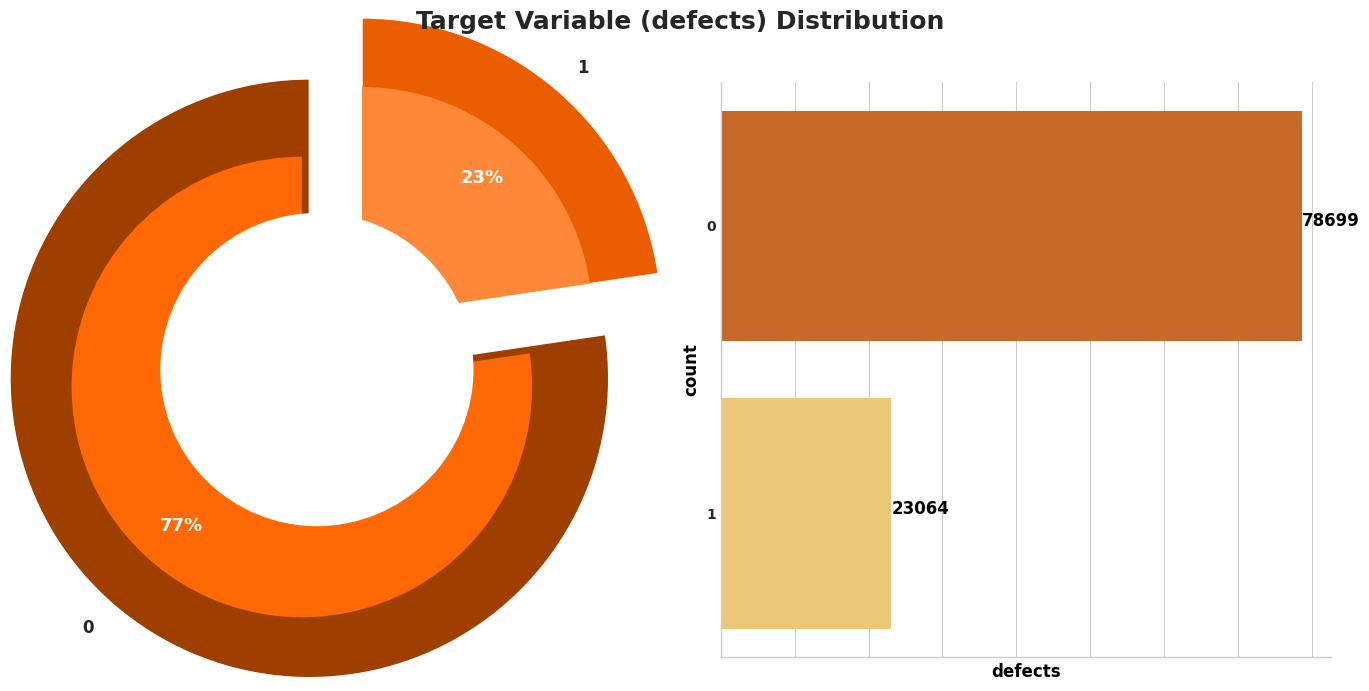

In [8]:
# https://www.kaggle.com/code/kimtaehun/eda-and-baseline-with-multiple-models
def plot_count(
    df: pd.core.frame.DataFrame, col: str, title_name: str = "Train"
) -> None:
    # Set background color

    f, ax = plt.subplots(1, 2, figsize=(14, 7))
    plt.subplots_adjust(wspace=0.2)

    s1 = df[col].value_counts()
    N = len(s1)

    outer_sizes = s1
    inner_sizes = s1 / N

    outer_colors = ["#9E3F00", "#eb5e00", "#ff781f"]
    inner_colors = ["#ff6905", "#ff8838", "#ffa66b"]

    ax[0].pie(
        outer_sizes,
        colors=outer_colors,
        labels=s1.index.tolist(),
        startangle=90,
        frame=True,
        radius=1.3,
        explode=([0.05] * (N - 1) + [0.3]),
        wedgeprops={"linewidth": 1, "edgecolor": "white"},
        textprops={"fontsize": 12, "weight": "bold"},
    )

    textprops = {"size": 13, "weight": "bold", "color": "white"}

    ax[0].pie(
        inner_sizes,
        colors=inner_colors,
        radius=1,
        startangle=90,
        autopct="%1.f%%",
        explode=([0.1] * (N - 1) + [0.3]),
        pctdistance=0.8,
        textprops=textprops,
    )

    center_circle = plt.Circle((0, 0), 0.68, color="black", fc="white", linewidth=0)
    ax[0].add_artist(center_circle)

    x = s1
    y = s1.index.tolist()
    sns.barplot(
        x=x,
        y=y,
        ax=ax[1],
        palette="YlOrBr_r",
        orient="horizontal",
    )

    ax[1].spines["top"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    ax[1].tick_params(axis="x", which="both", bottom=False, labelbottom=False)

    for i, v in enumerate(s1):
        ax[1].text(v, i, str(v), color="black", fontweight="bold", fontsize=12)

    plt.setp(ax[1].get_yticklabels(), fontweight="bold")
    plt.setp(ax[1].get_xticklabels(), fontweight="bold")
    ax[1].set_xlabel(col, fontweight="bold", color="black")
    ax[1].set_ylabel("count", fontweight="bold", color="black")

    f.suptitle(f"{title_name}", fontsize=18, fontweight="bold")
    plt.tight_layout()
    plt.show()


plot_count(df_train, target, f"Target Variable ({ target }) Distribution")

## Numerical features distribution


Due to the data is right-skewed, I'll use a log1p function to transform the data to be closer to a normal distribution. Plus, it will be easier to see patterns in the data
We can see that the distributions of the train and test data are the same. Thus, it wouldn't be a good idea to delete any values in the train dataset. At this point, I decided to focus on model development.


In [9]:
def plot_numerical(df: pd.DataFrame, hue=None, transform_function=None):
    numerical = df.select_dtypes(include=["number"]).columns
    df_ = df[numerical]
    if transform_function is not None:
        df_ = transform_function(df[numerical])
    fig = plt.figure(figsize=(14, len(numerical) * 3))

    for i, col in enumerate(numerical):
        plt.subplot(len(numerical), 2, i + 1)
        if hue is not None:
            sns.kdeplot(x=col, hue=df[hue], data=df_, palette="crest")
        else:
            sns.kdeplot(x=col, data=df_, palette="crest")

    plt.tight_layout()
    plt.show()

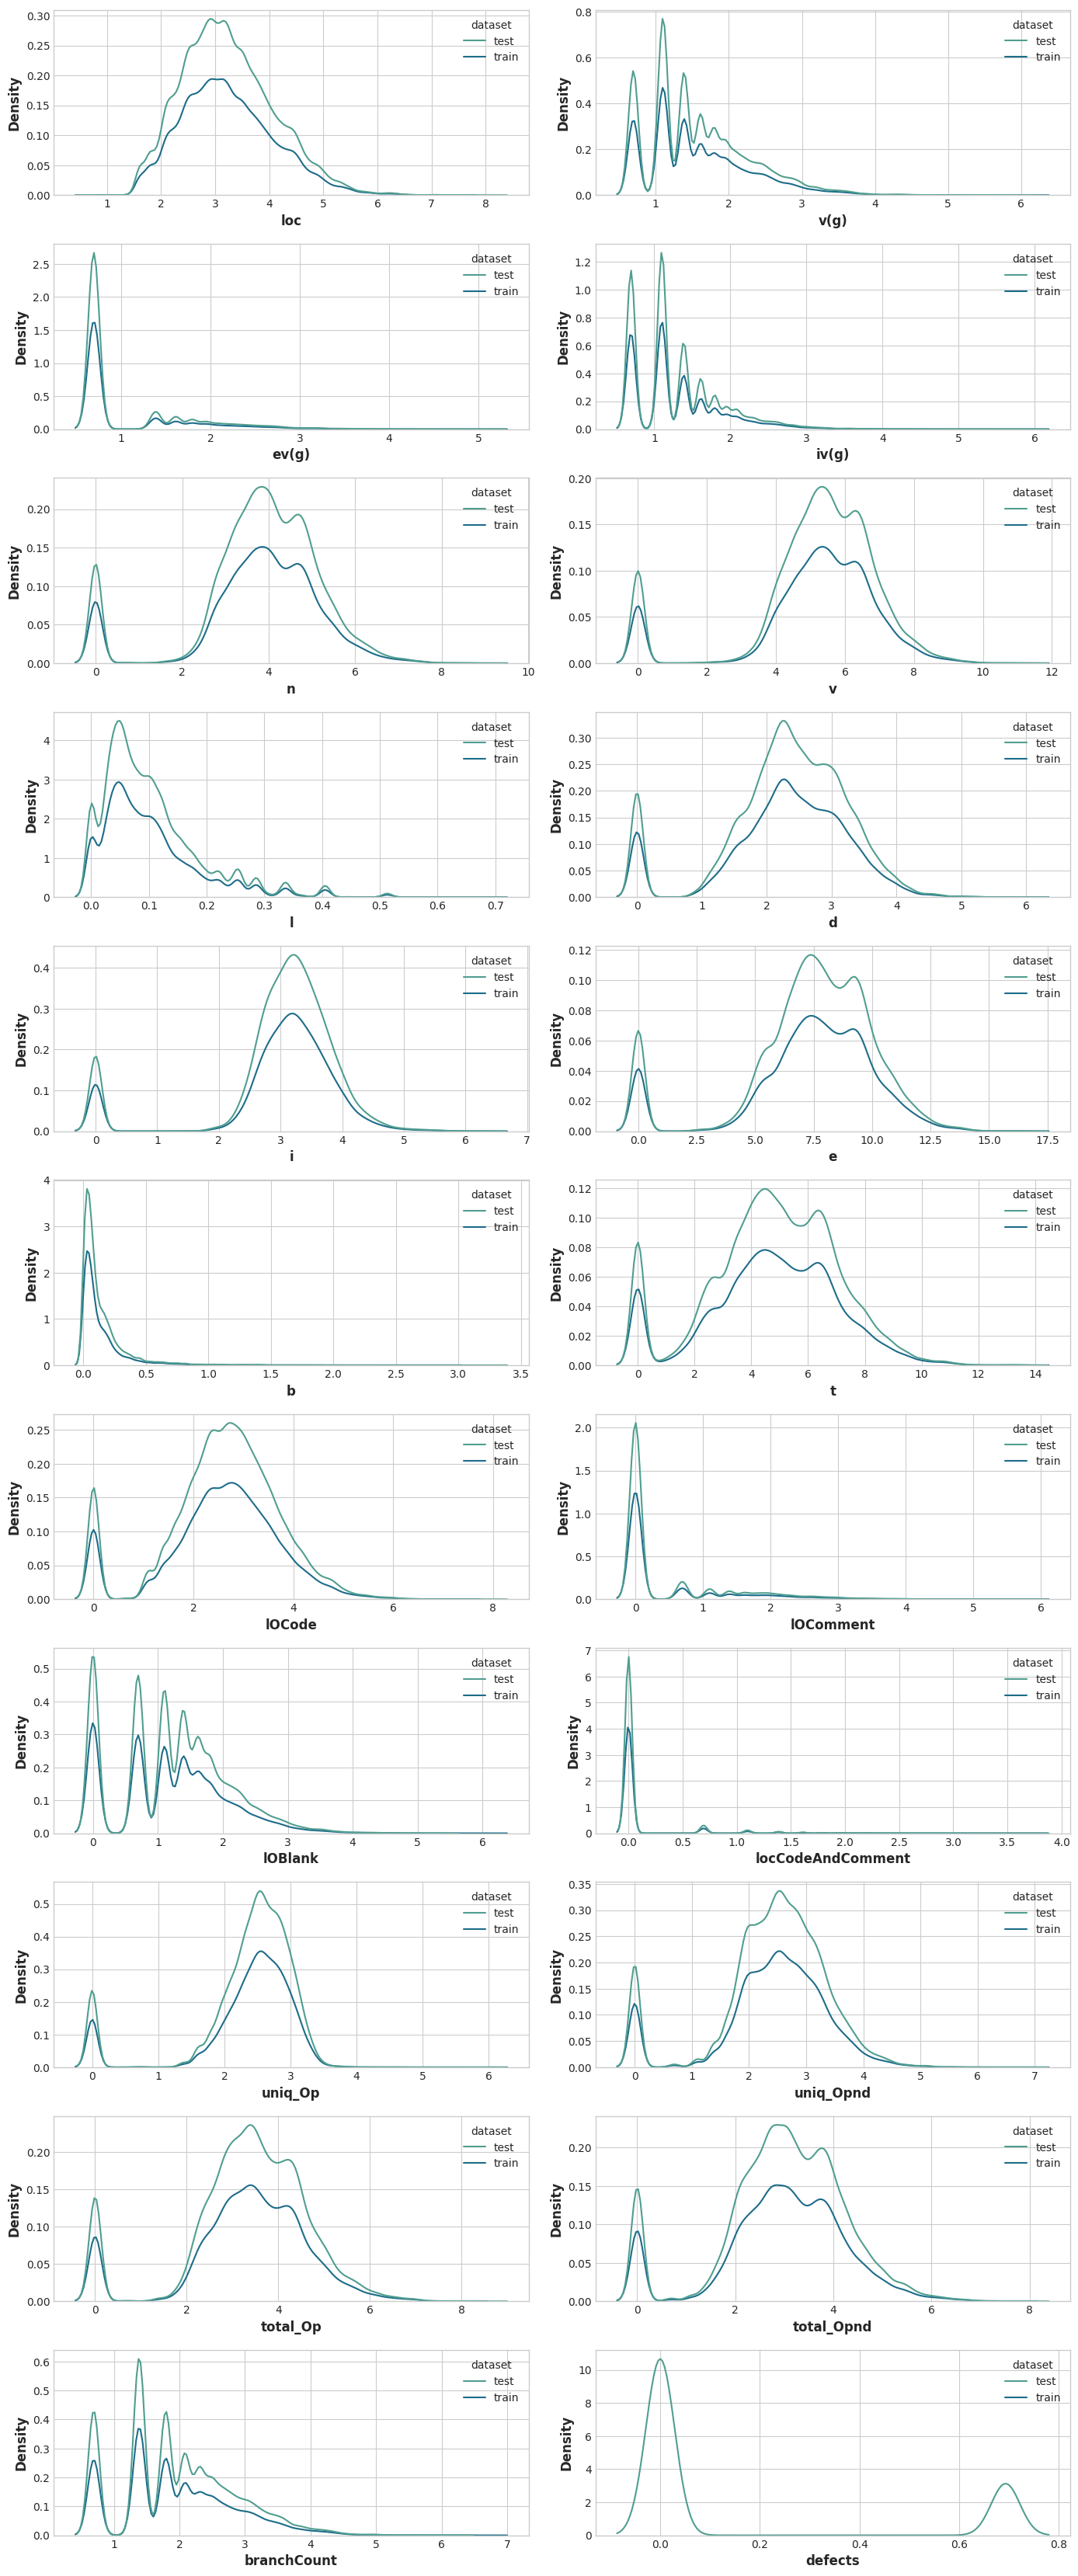

In [10]:
df_ = df.copy()

df_ = add_dataset(df_)

plot_numerical(df_, hue="dataset", transform_function=np.log1p)

## Mutual information


In [11]:
from sklearn.feature_selection import mutual_info_regression


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=rng
    )
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

Mutual information shows us that almost all of the features have an effect on the deffect value. I tried to select the top features, but it didn't increase the score.


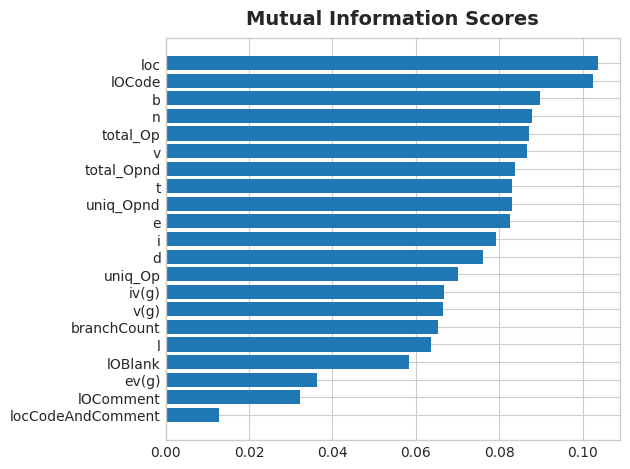

In [12]:
X = df_train.copy()
y = X.pop(target)

mi_scores = make_mi_scores(X, y)
plot_mi_scores(mi_scores)

## Correlation between features


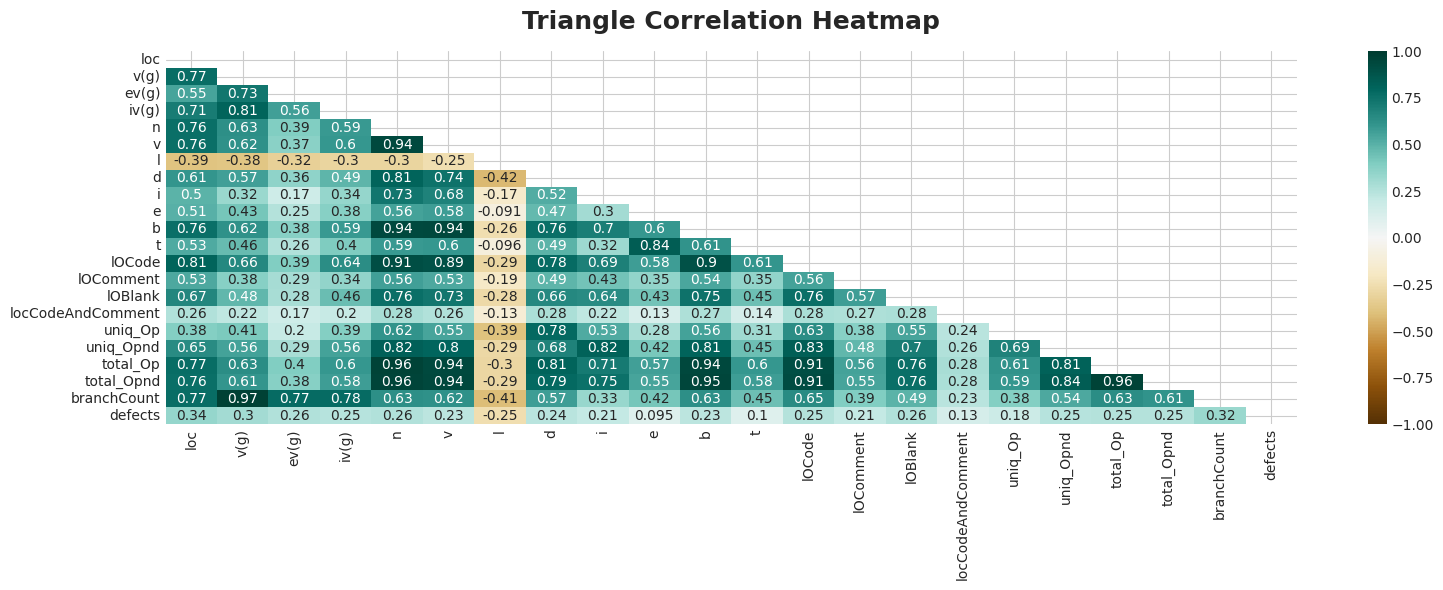

In [13]:
def triangle_heatmap(df):
    plt.figure(figsize=(16, 6))
    # define the mask to set the values in the upper triangle to True
    mask = np.triu(np.ones_like(df.corr(), dtype="bool"))
    heatmap = sns.heatmap(
        df.corr(method="pearson"),
        mask=mask,
        vmin=-1,
        vmax=1,
        annot=True,
        cmap="BrBG",
    )
    heatmap.set_title("Triangle Correlation Heatmap", fontdict={"fontsize": 18}, pad=16)
    plt.show()


df_numerical = df[get_numerical(df)]
triangle_heatmap(df_numerical)

# Data preprocessing


In [14]:
def load_data(PATH, test=True):
    # Read data
    data_dir = Path(PATH)
    df = pd.read_csv(data_dir / "train.csv")
    df[target] = df[target].astype("int")
    id_train = df.index
    if test:
        # Merge the splits so we can process them together
        df_test = pd.read_csv(data_dir / "test.csv")
        id_test = df_test.index + len(id_train)
        df = pd.concat([df, df_test], ignore_index=True)

    # Reform splits
    df_train = df.loc[id_train, :]
    if test:
        df_test = df.loc[id_test, :]
        return df_train, df_test
    return df_train

# Normalization


In [15]:
def normalize(df: pd.DataFrame):
    numerical = get_numerical(df)
    df[numerical] = np.log1p(df[numerical])
    return df

## Scaling


In [16]:
from sklearn.preprocessing import MinMaxScaler


def minmax_scaling(X_train: pd.DataFrame, X_test: pd.DataFrame = None):
    columns = X_train.columns

    minmax = MinMaxScaler()

    X_train_scaled = pd.DataFrame(minmax.fit_transform(X_train), columns=columns)

    if X_test is not None:
        X_test_scaled = pd.DataFrame(minmax.transform(X_test), columns=columns)

        return X_train_scaled, X_test_scaled

    return X_train_scaled

# Feature engineering


In [17]:
def mathematical_transforms(df: pd.DataFrame):
    X = pd.DataFrame()

    X["loc_lOCode"] = df["loc"] + df["lOCode"]
    X["Halstead sum"] = df.iloc[:, 5:12].sum(axis=1)

    return X

In [18]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


def cluster_labels(df, features, idx_train, n_clusters=20):
    X = df.copy()
    X_scaled = X.loc[:, features]
    st_scaler = StandardScaler().fit(X_scaled.loc[idx_train])
    X_scaled[features] = st_scaler.transform(X_scaled[features])

    kmeans = KMeans(n_clusters=n_clusters, n_init=50, random_state=0).fit(
        X_scaled.loc[idx_train]
    )
    X_new = pd.DataFrame()
    X_new["Cluster"] = kmeans.predict(X_scaled)
    return X_new

In [19]:
def create_features(df: pd.DataFrame, df_test=None):
    X = df.copy()

    # Combine splits if test data is given
    if df_test is not None:
        X_test = df_test.copy()
        if target in X_test.columns:
            X_test.pop(target)
        X = pd.concat([X, X_test])

    # New pandas features
    X = X.join(mathematical_transforms(X))

    # Drop unnecessary features
    X = X.drop(["id"], axis=1)

    # Reform splits
    if df_test is not None:
        X_test = X.loc[df_test.index, :]
        X.drop(df_test.index, inplace=True)

    if df_test is not None:
        return X, X_test
    else:
        return X

## Prepare dataset function


In [20]:
def prepare_dataset(X_train, X_test=None, scale=True):
    if X_test is not None:
        X_train, X_test = normalize(X_train), normalize(X_test)
        X_train, X_test = create_features(X_train, X_test)

        if scale:
            X_train, X_test = minmax_scaling(X_train, X_test)

        return X_train, X_test
    else:
        X_train = normalize(X_train)
        X_train = create_features(X_train)

        if scale:
            X_train = minmax_scaling(X_train)

        return X_train

# Cross-validation


In [21]:
from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold


def score_dataset(
    X: pd.DataFrame,
    y: pd.Series,
    model=XGBClassifier(),
    transform=False,
    features=None,
    verbose: int = 0,
    scale=True,
):
    if verbose == 1:
        print(f"Cross-validation of { model.__class__.__name__ }...")
    score = []
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    skf = StratifiedKFold(random_state=rng, shuffle=True, n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        if transform:
            X_train, X_test = prepare_dataset(X_train, X_test, scale=scale)

        if features is not None:
            X_train, X_test = X_train[features], X_test[features]

        model_local = clone(model)
        model_local.fit(X_train, y_train)

        fold_score = roc_auc_score(y_test, model_local.predict_proba(X_test)[:, 1])
        if verbose == 1:
            print(f"Split { i }:", fold_score)
        score.append(fold_score)

    return score

# Baseline


In [22]:
X = pd.read_csv(data_dir / "train.csv")
y = X.pop(target)

model = XGBClassifier()
print("The mean AUC score:", np.mean(score_dataset(X, y, verbose=1)))

Cross-validation of XGBClassifier...
Split 0: 0.7849781678814444
Split 1: 0.7850118966591019
Split 2: 0.7818585038525727
Split 3: 0.7837944781912496
Split 4: 0.7808667777799095
The mean AUC score: 0.7833019648728555


# Hyperparameter tuning


## GaussianNB


In [23]:
# X = load_data(PATH, test=False)
# y = X.pop(target)


# def objective(trial: optuna.trial.Trial):
#     params = dict(
#         var_smoothing=trial.suggest_float("var_smoothing", 1e-9, 1e-1, log=True)
#     )
#     model = GaussianNB(**params)

#     return np.mean(score_dataset(X, y, model, transform=True))


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=10)
# gausNB_params = study.best_params

## K-nearest neighbor


In [24]:
# X = load_data(PATH, test=False)
# y = X.pop(target)


# def objective(trial: optuna.trial.Trial):
#     params = dict(
#         n_neighbors=trial.suggest_int("n_neighbors", 3, 21, 2),
#         weights=trial.suggest_categorical("weights", ["uniform", "distance"]),
#         # leaf_size = trial.suggest_int('leaf_size', 10, 50, 5),
#         p=trial.suggest_categorical("p", [1, 2]),
#     )
#     model = KNeighborsClassifier(**params)

#     return np.mean(score_dataset(X, y, model, transform=True))


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
# knn_params = study.best_params

## RGF


In [25]:
# X = load_data(PATH, test=False)
# y = X.pop(target)


# def objective(trial: optuna.trial.Trial):
#     params = dict(
#         loss="Log",
#         algorithm=trial.suggest_categorical("algorithm", ["RGF", "RGF_Sib"]),
#         max_leaf=trial.suggest_int("max_leaf", 500, 1500),
#         l2=trial.suggest_float("l2", 1e-4, 1e1, log=True),
#         reg_depth=trial.suggest_int("reg_depth", 1, 10),
#         test_interval=trial.suggest_int("test_interval", 100, 1000, 100),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e1, log=True),
#     )
#     model = RGFClassifier(**params)

#     return np.mean(score_dataset(X, y, model, transform=True, scale=False))


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=30)
# rgf_params = study.best_params
# print(rgf_params)

## Neural network


In [26]:
# X = load_data(PATH, test=False)
# y = X.pop(target)


# def objective(trial: optuna.trial.Trial):
#     params = dict(
#         hidden_layer_sizes=(
#             trial.suggest_int("level_1", 50, 150, 10),
#             trial.suggest_int("level_2", 50, 150, 10),
#         ),
#         learning_rate_init=trial.suggest_float("learning_rate", 1e-3, 1, log=True),
#         random_state=rng,
#     )
#     model = MLPClassifier(**params)

#     return np.mean(score_dataset(X, y, model, transform=True))


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
# nn_params = study.best_params
# print(nn_params)

## LightGBM


In [27]:
# X = load_data(PATH, test=False)
# y = X.pop(target)


# def objective(trial: optuna.trial.Trial):
#     params = {
#         "objective": "binary",
#         "metric": "auc",
#         "learning_rate": trial.suggest_loguniform("learning_rate", 1e-3, 1e-2),
#         "is_unbalance": trial.suggest_categorical("is_balance", [True, False]),
#         "lambda_l1": trial.suggest_loguniform("lambda_l1", 1e-8, 10.0),
#         "lambda_l2": trial.suggest_loguniform("lambda_l2", 1e-8, 10.0),
#         "num_leaves": trial.suggest_int("num_leaves", 10, 100),
#         "max_depth": trial.suggest_int("max_depth", 15, 100),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
#         "feature_fraction": trial.suggest_uniform("feature_fraction", 0.1, 1.0),
#         "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.1, 1.0),
#         "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
#         "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
#         "verbosity": -1,
#     }
#     model = LGBMClassifier(**params)

#     return np.mean(score_dataset(X, y, model, transform=True, scale=False))


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)
# lgbm_params = study.best_params

## HistGradientBoosting


In [28]:
# X = load_data(PATH, test=False)
# y = X.pop(target)


# def objective(trial: optuna.trial.Trial):
#     params = dict(
#         learning_rate=trial.suggest_float("learning_rate", 0.001, 1),
#         max_iter=trial.suggest_int("max_iter", 50, 150),
#         max_leaf_nodes=trial.suggest_int("max_leaf_nodes", 2, 50),
#         max_depth=trial.suggest_int("max_depth", 2, 15),
#         min_samples_leaf=trial.suggest_int("min_samples_leaf", 10, 30),
#         l2_regularization=trial.suggest_float("l2_regularization", 0, 1),
#         max_bins=trial.suggest_int("max_bins", 2, 255),
#     )
#     model = HistGradientBoostingClassifier(**params, random_state=rng)

#     return np.mean(score_dataset(X, y, model, transform=True, scale=False))


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=100)
# hist_params = study.best_params

## XGBoost


In [29]:
# X = load_data(PATH, test=False)
# y = X.pop(target)


# def objective(trial):
#     xgb_params = dict(
#         max_depth=trial.suggest_int("max_depth", 2, 10),
#         learning_rate=trial.suggest_float("learning_rate", 1e-4, 1e-1, log=True),
#         n_estimators=trial.suggest_int("n_estimators", 100, 1500),
#         min_child_weight=trial.suggest_int("min_child_weight", 1, 10),
#         colsample_bytree=trial.suggest_float("colsample_bytree", 0.2, 1.0),
#         subsample=trial.suggest_float("subsample", 0.2, 1.0),
#         reg_alpha=trial.suggest_float("reg_alpha", 1e-4, 1e2, log=True),
#         reg_lambda=trial.suggest_float("reg_lambda", 1e-4, 1e2, log=True),
#     )
#     model = XGBClassifier(**xgb_params)
#     return np.mean(score_dataset(X, y, model, transform=True, scale=False))


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
# xgb_params = study.best_params

## Logistic regression


In [30]:
# X = load_data(PATH, test=False)
# y = X.pop(target)


# def objective(trial: optuna.trial.Trial):
#     log_params = dict(
#         penalty="l2",
#         # rangom_state=rng,
#         C=trial.suggest_uniform("C", 0.01, 1),
#         class_weight=trial.suggest_categorical("class_weight", [None, "balanced"]),
#         solver=trial.suggest_categorical(
#             "solver",
#             ["lbfgs", "liblinear", "newton-cg", "newton-cholesky", "sag", "saga"],
#         ),
#     )
#     model = LogisticRegression(**log_params)

#     return np.mean(score_dataset(X, y, model, transform=True))


# study = optuna.create_study(direction="maximize")
# study.optimize(objective, n_trials=20)
# log_params = study.best_params

## Final scoring of the base models


### The best parameters


In [31]:
log_params = {"C": 0.9908157077539047, "class_weight": "balanced", "solver": "sag"}
gausNB_params = {"var_smoothing": 0.0016667105667259854}
lgbm_params = {
    "objective": "binary",
    "metric": "auc",
    "lambda_l1": 1.6654273563790903e-05,
    "lambda_l2": 0.02014726478845929,
    "num_leaves": 11,
    "feature_fraction": 0.6954069255802414,
    "bagging_fraction": 0.7519538569846249,
    "bagging_freq": 1,
    "min_child_samples": 84,
}
hist_params = {
    "learning_rate": 0.20560829676545686,
    "max_iter": 136,
    "max_leaf_nodes": 48,
    "max_depth": 2,
    "min_samples_leaf": 25,
    "l2_regularization": 0.4193669652311204,
    "max_bins": 95,
}
xgb_params = {
    "max_depth": 6,
    "learning_rate": 0.008132723400312207,
    "n_estimators": 1132,
    "min_child_weight": 9,
    "colsample_bytree": 0.23798027598280524,
    "subsample": 0.8215953366389674,
    "reg_alpha": 0.7345440373240789,
    "reg_lambda": 0.0031933529046844025,
}
knn_params = {"n_neighbors": 21, "weights": "distance", "p": 1}
rgf_params = {
    "algorithm": "RGF",
    "max_leaf": 946,
    "l2": 0.000809059291077585,
    "reg_depth": 8,
    "test_interval": 600,
    "learning_rate": 1.020128245525047,
}

nn_params = {
    "hidden_layer_sizes": (110, 50),
    "learning_rate_init": 0.001,
    "random_state": rng,
}

### Base models


In [32]:
tree_models = [
    ("lgbm", LGBMClassifier(**lgbm_params, verbosity=-1)),
    ("xgboost", XGBClassifier(**xgb_params)),
    ("hist", HistGradientBoostingClassifier(**hist_params, random_state=rng)),
    ("rgf", RGFClassifier(**rgf_params)),
]

other_models = [
    ("logistic", LogisticRegression(**log_params)),
    ("knn", KNeighborsClassifier(**knn_params)),
    (
        "nn",
        MLPClassifier(**nn_params),
    ),
    ("gausNB", GaussianNB(**gausNB_params)),
]

### Scoring


In [33]:
X = load_data(PATH, test=False)
y = X.pop(target)

In [34]:
for model in tree_models:
    print(f"{ model[0]} AUC score:")
    print(
        np.mean(score_dataset(X, y, model[1], transform=True, scale=False, verbose=0))
    )

lgbm AUC score:
[LightGBM] [Warning] bagging_fraction is set=0.7519538569846249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519538569846249
[LightGBM] [Warning] lambda_l2 is set=0.02014726478845929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02014726478845929
[LightGBM] [Warning] lambda_l1 is set=1.6654273563790903e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6654273563790903e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6954069255802414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6954069255802414
[LightGBM] [Warning] bagging_fraction is set=0.7519538569846249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519538569846249
[LightGBM] [Warning] lambda_l2 is set=0.02014726478845929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02014726478845929
[LightGBM] [War

In [35]:
for model in other_models:
    print(f"{ model[0]} AUC score:")
    print(np.mean(score_dataset(X, y, model[1], transform=True, scale=True, verbose=0)))

logistic AUC score:
0.7870983941155256
knn AUC score:
0.7651970454209974
nn AUC score:
0.7914238538953688
gausNB AUC score:
0.7687341144353199


# Stacking ensemble


## Base models


In [36]:
def base_models_predictions(X: pd.DataFrame, y: pd.Series, models: list, scale=True):
    meta_train_index = []
    predictions = [list() for _ in range(len(models))]
    skf = StratifiedKFold(random_state=rng, shuffle=True, n_splits=5)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Split { i }...")
        X_train, X_test = X.loc[train_index], X.loc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        meta_train_index.extend(test_index)

        X_train, X_test = prepare_dataset(X_train, X_test, scale=scale)

        for j in range(len(models)):
            print(f"{ models[j][0] } training...")
            temp_model = clone(models[j][1])
            temp_model.fit(X_train, y_train)
            predictions[j].extend(temp_model.predict_proba(X_test)[:, 1])

    arr_predictions = np.array(predictions)

    df_predictions = pd.DataFrame(
        arr_predictions.T,
        index=meta_train_index,
        columns=[m[0] for m in models],
    )

    return df_predictions.loc[X.index]

In [37]:
X = load_data(PATH, test=False)
y = X.pop(target)

train_tree_predictions = base_models_predictions(X, y, tree_models, scale=False)
train_other_predictions = base_models_predictions(X, y, other_models, scale=True)
train_predictions = pd.concat([train_tree_predictions, train_other_predictions], axis=1)

Split 0...
lgbm training...
[LightGBM] [Warning] bagging_fraction is set=0.7519538569846249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519538569846249
[LightGBM] [Warning] lambda_l2 is set=0.02014726478845929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02014726478845929
[LightGBM] [Warning] lambda_l1 is set=1.6654273563790903e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6654273563790903e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6954069255802414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6954069255802414
xgboost training...
hist training...
rgf training...
Split 1...
lgbm training...
[LightGBM] [Warning] bagging_fraction is set=0.7519538569846249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519538569846249
[LightGBM] [Warning] lambda_l2 is set=0.02014726478845929,

In [38]:
train_predictions.head()

,lgbm,xgboost,hist,rgf,logistic,knn,nn,gausNB
0,0.078330,0.074333,0.079220,0.077303,0.302803,0.164319,0.078747,1.176026e-05
1,0.057949,0.059219,0.063494,0.054735,0.239503,0.117319,0.067419,2.835908e-07
2,0.048693,0.050785,0.041446,0.038315,0.198215,0.059550,0.047139,3.071317e-07
3,0.100079,0.094140,0.094235,0.106117,0.182546,0.065010,0.073197,7.436219e-08
4,0.107176,0.113574,0.105406,0.116510,0.232238,0.039937,0.121523,2.681122e-07


In [39]:
for model in train_predictions:
    auc_score = roc_auc_score(y, train_predictions[model])
    print(f"{model} AUC score: {auc_score}")

lgbm AUC score: 0.7924188228389895
xgboost AUC score: 0.7929253944007396
hist AUC score: 0.7917608916161053
rgf AUC score: 0.7921062049634559
logistic AUC score: 0.7870831120193782
knn AUC score: 0.7652044626475132
nn AUC score: 0.7905319686259042
gausNB AUC score: 0.7687096394162266


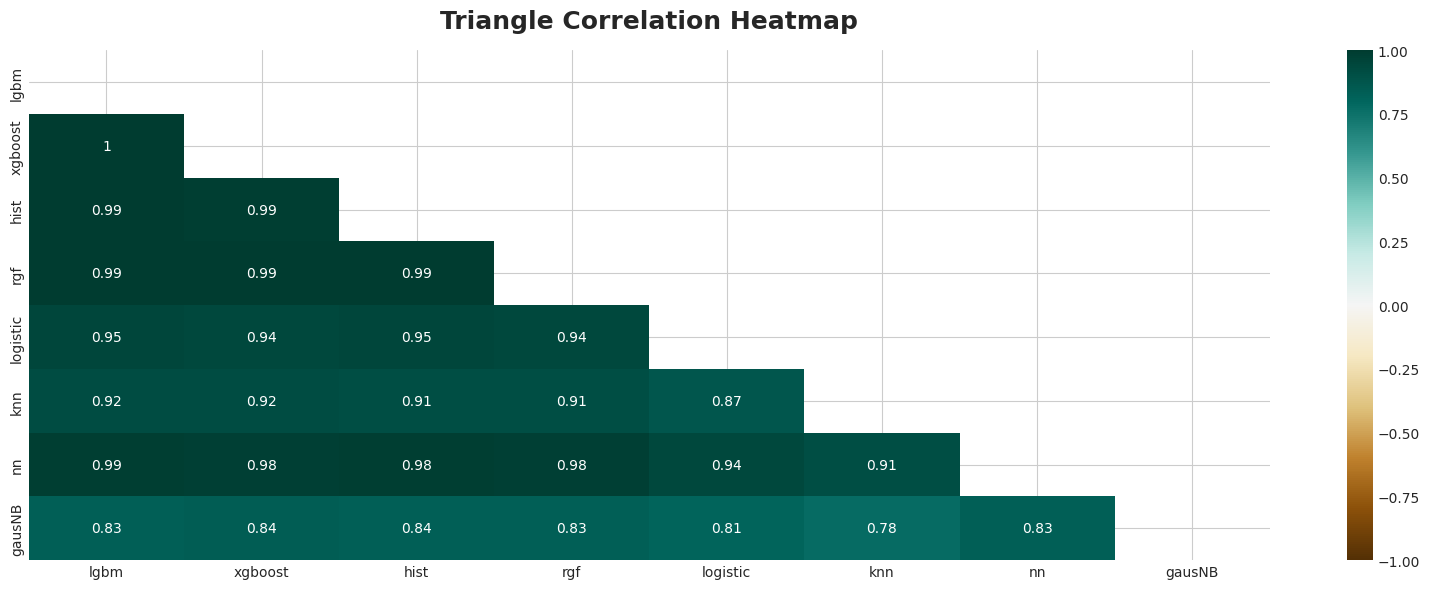

In [40]:
triangle_heatmap(train_predictions)

## Meta-model


The neural network model shows us the best score


In [41]:
from sklearn.linear_model import SGDClassifier

meta_models = [
    ("cat_boost", CatBoostClassifier(verbose=0, iterations=200)),
    ("lgbm", LGBMClassifier(verbose=-1)),
    ("xgb", XGBClassifier()),
    ("logistic", LogisticRegression()),
    ("sgd", SGDClassifier(loss="log_loss")),
    ("nn", MLPClassifier(hidden_layer_sizes=(100, 100), random_state=rng)),
    ("gausNB", GaussianNB()),
    ("hist", HistGradientBoostingClassifier(random_state=rng)),
]

for meta_model in meta_models:
    print(f"{ meta_model[0] } model:")
    print(np.mean(score_dataset(train_predictions, y, meta_model[1])))

cat_boost model:
0.7855328621128597
lgbm model:
0.7909222489388139
xgb model:
0.7865339036091143
logistic model:
0.791354955379836
sgd model:
0.7914407655729944
nn model:
0.793371275640094
gausNB model:
0.7906265390683489
hist model:
0.7919028670203645


# Train model and make predictions


In [42]:
X_train, X_test = load_data(PATH, test=True)
y = X_train.pop(target)

X_train, X_test = prepare_dataset(X_train, X_test, scale=False)

test_predictions = pd.DataFrame(index=X_test.index)
for model in tree_models:
    model[1].fit(X_train, y)
    test_prediction = model[1].predict_proba(X_test)[:, 1]
    test_predictions[model[0]] = test_prediction.T

X_train, X_test = minmax_scaling(X_train, X_test)
for model in other_models:
    model[1].fit(X_train, y)
    test_prediction = model[1].predict_proba(X_test)[:, 1]
    test_predictions[model[0]] = test_prediction.T

meta_params = dict(
    hidden_layer_sizes=(100, 100),
    random_state=rng,
)
meta_model = MLPClassifier(**meta_params)
meta_model.fit(train_predictions, y)


sub_predictions = meta_model.predict_proba(test_predictions)[:, 1]

submission = pd.read_csv(data_dir / "sample_submission.csv")
submission["defects"] = sub_predictions
submission.to_csv("submission.csv", index=False)

[LightGBM] [Warning] bagging_fraction is set=0.7519538569846249, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7519538569846249
[LightGBM] [Warning] lambda_l2 is set=0.02014726478845929, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02014726478845929
[LightGBM] [Warning] lambda_l1 is set=1.6654273563790903e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6654273563790903e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] feature_fraction is set=0.6954069255802414, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6954069255802414
